# <center> École des Ponts ParisTech</center>
## <center> SPH pour l'hydraulique </center>
### <center> Projet SPH GMM 2021</center>
#### <center> Parois mobiles  </center>
<center> Auteurs : Ruben Persicot & Yohan Lanier </center>


<center> Encadrants : Rémi Carmigniani et Damien Violeau </center>


<img src='./Figures/logo_p.jpg' width=200>

## 3. Etude d'un écoulement suite à la chute d'un solide.

### 3.1 Explication de la situation étudiée.

### 3.2 Etude numérique

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
from src.spyh import *
from src.checkTD3 import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.analytical_solutions import *
from src.solidStuffManagement import *

In [2]:
#FLUID PARAMETERS 
e = 0.5 #half width in meters
U = 1 # Upper bound velocity
Re = 1 # Reynolds number
#FLUID PARAMETERS
rhoF = 1000
mu = 200 #(Pa.s)
print(mu)
grav = np.array([0.0,-9.81])#np.array([0.0,-9.81])#np.array([0.0,0.0]) #m.s-2#OTHER FLUID PARAMETERS
c0 = 10*U
gamma = 7
B = rhoF*c0**2/gamma 
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF


200


In [3]:
#GEOMETRY
Lx = 2
Ly = 2
lx = 0.5
ly=1
#PARTICLES & SPACES PARAMETERS : 
dr = ly/20
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
#SOLID PARAMETERS
ls = 0.4
ws = 0.2
rhoS = 100
ms = dr*dr*rhoS 
print(ms)
#COMPUTATION DOMAIN : 
xOrigin = -nBound*dr
yOrigin = -nBound*dr
xSize = Lx+2*nBound*dr
ySize = Ly+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize
#INIT SPACES & PART:
posSpace,neibSpace,partSpace,listNeibSpace = \
init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr)
part = init_particles()

0.25000000000000006


In [4]:
#INIT PART:
#% COMPLETE HERE
part = addBox(part,[Lx,Ly/2],FLUID,dr,rhoF)
part = addBox(part,[-nBound*dr,-nBound*dr,Lx+2*nBound*dr,nBound*dr],BOUND,dr,rhoF)
part = addBox(part,[-nBound*dr,0,nBound*dr,Ly],BOUND,dr,rhoF)
part = addBox(part,[Lx,0,nBound*dr,Ly],BOUND,dr,rhoF)
numberOfNonSolidParticles = len(part)
part = addBox(part,[(Lx-ws)/2, (Ly-ls), ws, ls], MOBILESOLID, dr, rhoS)
part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
numberOfSolidPart = len(part)-numberOfNonSolidParticles
# END

<IPython.core.display.Javascript object>


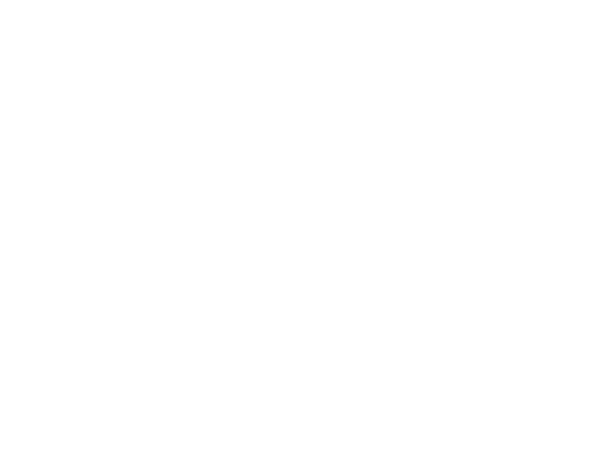

In [5]:
%matplotlib notebook
Umax= 1
tabUx = part[:,VEL[0]]
domain = [xOrigin,xMax,yOrigin,yMax,0,Umax]
plotPropertiesWithBound(part,tabUx,r'$U_x$',domain,dr,1)

In [6]:
plotSpaces(posSpace,'k',lspace,1)
neibSpace[2][neibSpace[2]>-1]
spacesOutline(posSpace[neibSpace[2][neibSpace[2]>-1]],'r',lspace,1)

Initialisation de la pression

In [7]:
def initWaterPressure(part):
    infoTab = part[:,INFO]
    y_i = part[infoTab == FLUID] [:,POS[1]]
    p_i = np.linalg.norm(grav)*rhoF*(Ly/2-y_i)
    rho_i = density(p_i,B,rhoF,gamma)
    part[infoTab == FLUID, RHO] = rho_i
    return part

<IPython.core.display.Javascript object>


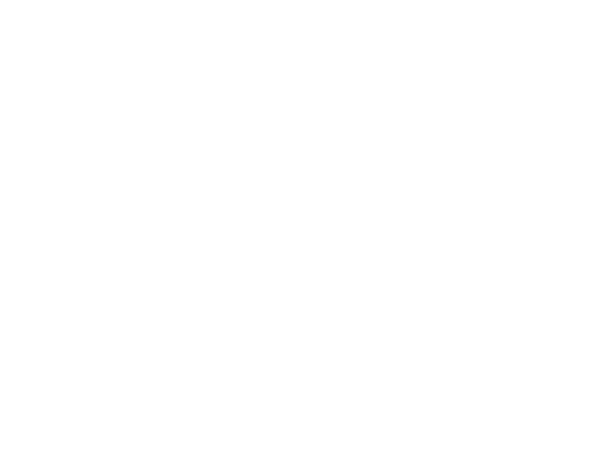

In [8]:
part = initWaterPressure(part)
%matplotlib notebook
Pmax= rhoF*np.linalg.norm(grav)*Ly/2
tabPres = pressure(part[:,RHO],B,rhoF,gamma)
domain = [xOrigin,xMax,yOrigin,yMax,0,Pmax]
plotPropertiesWithBound(part,tabPres,r'Pressure',domain,dr,1)

In [9]:
#Managing the center of mass
#OG = computeCenterOfMass(part, numberOfSolidPart)
infoTab = part[:,INFO]
OG = np.array([1/numberOfSolidPart*np.sum(part[infoTab == MOBILESOLID] [:,POS[0]]),1/numberOfSolidPart*np.sum(part[infoTab == MOBILESOLID] [:,POS[1]])])
print(OG)
V_OG = np.array([0,0])
A_OG = np.array([0,0])

[1.  1.8]


In [10]:
current_directory = os.getcwd()
case_directory = os.path.join(current_directory, r'Results/Floating_solid_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

In [11]:
# Here we specify the output frequencies
dt_figure = 0.005#0.025*e**2*rhoF/mu
t_print = 0
#final time :
t_end = 3
t=0
it=0
im_count=0

### 3.3 Simulation SPH

Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00e+00 -9.81e-06] [ 0.      -0.00981]
time
0.0010000000000000002


<IPython.core.display.Javascript object>


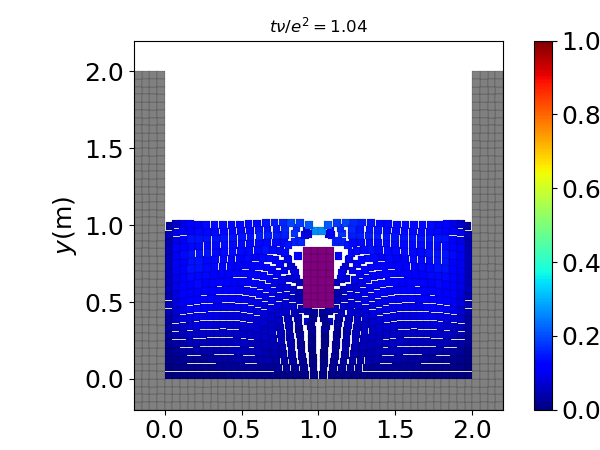

Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -1.95911669e-05] [ 0.         -0.01961039]
time
0.0019990199614178493
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -2.92672347e-05] [ 0.         -0.02938205]
time
0.0029951122529268764
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -3.88586292e-05] [ 0.         -0.03912521]
time
0.003988298713446644
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.0000000e+00 -4.8366654e-05] [ 0.         -0.04884011]
time
0.004978604676430668
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -5.77925126e-05] [ 0.       -0.058527]
time
0.0059660551161967515
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -6.71373839e-05] [ 0.         -0.06818612]
time
0.006950674647780792
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -7.64024233e-05] [ 0.        -0.0778177]
time
0.007932487534124366
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -8.55887634e-05] [ 0.         -0.08742199]

Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00054285] [ 0.         -0.64578117]
time
0.06582886500422079
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00054863] [ 0.         -0.65401044]
time
0.06666773131343687
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00055437] [ 0.         -0.66222269]
time
0.0675048615363135
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00056007] [ 0.         -0.67041801]
time
0.06834026642453767
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00056574] [ 0.         -0.67859651]
time
0.06917395661916952
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00057137] [ 0.        -0.6867583]
time
0.07000594265223055
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00057697] [ 0.         -0.69490346]
time
0.07083623494826255
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00058254] [ 0.         -0.70303212]
time
0.0716648438258579
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[

Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00087691] [ 0.         -1.18563673]
time
0.1208600133019183
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00088085] [ 0.         -1.19288065]
time
0.12159843490596348
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00088477] [ 0.         -1.20011294]
time
0.12233567218009149
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00088867] [ 0.         -1.20733368]
time
0.12307173081169642
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00089255] [ 0.         -1.21454291]
time
0.12380661644276364
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00089641] [ 0.         -1.22174068]
time
0.12454033467037598
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00090026] [ 0.         -1.22892706]
time
0.1252728910472128
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00090409] [ 0.        -1.2361021]
time
0.12600429108204173
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[

Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00111093] [ 0.         -1.66079704]
time
0.1692963345416307
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00111385] [ 0.         -1.66735047]
time
0.1699643699238794
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00111675] [ 0.         -1.67389529]
time
0.17063152830617026
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00111965] [ 0.         -1.68043155]
time
0.17129781313696732
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00112253] [ 0.         -1.68695927]
time
0.1719632278421803
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.        -0.0011254] [ 0.         -1.69347848]
time
0.17262777582537067
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00112826] [ 0.         -1.69998923]
time
0.17329146046795532
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.        -0.0011311] [ 0.         -1.70649154]
time
0.17395428512940786
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.

time
0.21349657395538002
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00129089] [ 0.         -2.10043047]
time
0.21411115932376262
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00129316] [ 0.         -2.10645286]
time
0.21472506176128603
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00129541] [ 0.         -2.11246856]
time
0.21533828354149667
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00129766] [ 0.         -2.11847761]
time
0.21595082692534764
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.        -0.0012999] [ 0.         -2.12448003]
time
0.21656269416129614
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00130213] [ 0.         -2.13047584]
time
0.21717388748539995
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00130436] [ 0.         -2.13646505]
time
0.21778440912141306
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00130658] [ 0.        -2.1424477]
time
0.21839426128088021
Force fluid -> soli

Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00143497] [ 0.        -2.5125864]
time
0.256125015659133
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00143678] [ 0.         -2.51818362]
time
0.25669557847433083
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00143859] [ 0.         -2.52377549]
time
0.257265594824322
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.        -0.0014404] [ 0.       -2.529362]
time
0.25783506627742864
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.        -0.0014422] [ 0.         -2.53494319]
time
0.25840399439448236
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.       -0.001444] [ 0.         -2.54051905]
time
0.25897238072887396
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00144579] [ 0.         -2.54608963]
time
0.25954022682660327
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00144757] [ 0.         -2.55165491]
time
0.2601075342263281
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.

Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00155376] [ 0.         -2.90273231]
time
0.29589524043526544
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00155526] [ 0.         -2.90797894]
time
0.2964300657229081
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00155675] [ 0.         -2.91322117]
time
0.2969644409150968
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00155824] [ 0.         -2.91845898]
time
0.2974983671470319
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00155973] [ 0.        -2.9236924]
time
0.298031845549148
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00156121] [ 0.         -2.92892145]
time
0.2985648772471421
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00156269] [ 0.         -2.93414612]
time
0.29909746336200094
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00156416] [ 0.         -2.93936643]
time
0.29962960501002894
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0. 

Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00165271] [ 0.         -3.26982386]
time
0.333315378625104
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00165397] [ 0.         -3.27477852]
time
0.33382044048575243
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00165522] [ 0.         -3.27972946]
time
0.33432512327968933
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00165648] [ 0.         -3.28467669]
time
0.33482942785964187
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00165773] [ 0.         -3.28962021]
time
0.33533335507514384
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00165898] [ 0.         -3.29456005]
time
0.3358369057725523
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00166022] [ 0.         -3.29949619]
time
0.33634008079506433
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00166147] [ 0.         -3.30442866]
time
0.33684288098273335
Force fluid -> solid :
[0. 0.]
dOG, V_OG :


Force fluid -> solid :
[-8.49098569e-13  3.16576502e+02]
dOG, V_OG :
[ 1.10817491e-20 -1.53069421e-03] [ 2.06579228e-17 -2.85342707e+00]
time
0.36367300996883156
Force fluid -> solid :
[-9.20152843e-13  3.06627439e+02]
dOG, V_OG :
[-2.21631546e-20 -1.52649298e-03] [-4.12062078e-17 -2.83808816e+00]
time
0.3642108695734032
Force fluid -> solid :
[-1.09778853e-12  2.97039725e+02]
dOG, V_OG :
[-6.21200912e-20 -1.52244011e-03] [-1.15201351e-16 -2.82335640e+00]
time
0.3647501001534746
Force fluid -> solid :
[-1.21147536e-12  2.87864650e+02]
dOG, V_OG :
[-1.06521535e-19 -1.51852940e-03] [-1.97059862e-16 -2.80920843e+00]
time
0.36529065434731345
Force fluid -> solid :
[-1.38200562e-12  2.79139141e+02]
dOG, V_OG :
[-1.57489640e-19 -1.51475397e-03] [-2.90661639e-16 -2.79561800e+00]
time
0.36583248587507067
Force fluid -> solid :
[-1.42108547e-12  2.70886747e+02]
dOG, V_OG :
[-2.10235938e-19 -1.51110654e-03] [-3.87129190e-16 -2.78255685e+00]
time
0.3663755499059351
Force fluid -> solid :
[-1.4885

Force fluid -> solid :
[1.30384592e-12 1.52892928e+02]
dOG, V_OG :
[ 2.02716395e-19 -1.39549849e-03] [ 3.49644569e-16 -2.40695118e+00]
time
0.3940115706437979
Force fluid -> solid :
[1.28252964e-12 1.51779942e+02]
dOG, V_OG :
[ 2.56899833e-19 -1.39373503e-03] [ 4.42680526e-16 -2.40163393e+00]
time
0.39459189848305
Force fluid -> solid :
[1.42819090e-12 1.50654821e+02]
dOG, V_OG :
[ 3.17375997e-19 -1.39199463e-03] [ 5.4637980e-16 -2.3963934e+00]
time
0.3951727691471562
Force fluid -> solid :
[1.51700874e-12 1.49518288e+02]
dOG, V_OG :
[ 3.81768972e-19 -1.39027775e-03] [ 6.56629700e-16 -2.39123063e+00]
time
0.3957541759461516
Force fluid -> solid :
[1.43174361e-12 1.48356536e+02]
dOG, V_OG :
[ 4.42723952e-19 -1.38858546e-03] [ 7.60777611e-16 -2.38614767e+00]
time
0.3963361120408992
Force fluid -> solid :
[1.54187774e-12 1.47178423e+02]
dOG, V_OG :
[ 5.08508035e-19 -1.38691838e-03] [ 8.73037560e-16 -2.38114593e+00]
time
0.3969185704120817
Force fluid -> solid :
[1.50635060e-12 1.45987867e

Force fluid -> solid :
[-2.80131474e-12  1.06298020e+02]
dOG, V_OG :
[-6.72287992e-19 -1.33670640e-03] [-1.12353188e-15 -2.23391206e+00]
time
0.425926614872739
Force fluid -> solid :
[-2.79598567e-12  1.06877909e+02]
dOG, V_OG :
[-7.97765197e-19 -1.33592775e-03] [-1.33273837e-15 -2.23178722e+00]
time
0.4265252058777122
Force fluid -> solid :
[-2.75335310e-12  1.07527968e+02]
dOG, V_OG :
[-9.21478012e-19 -1.33512863e-03] [-1.53883247e-15 -2.22961292e+00]
time
0.42712402220941575
Force fluid -> solid :
[-2.68229883e-12  1.08245507e+02]
dOG, V_OG :
[-1.04215285e-18 -1.33430723e-03] [-1.73968527e-15 -2.22738405e+00]
time
0.4277230689815893
Force fluid -> solid :
[-2.66631162e-12  1.09027479e+02]
dOG, V_OG :
[-1.16226103e-18 -1.33346183e-03] [-1.93941964e-15 -2.22509573e+00]
time
0.4283223518837903
Force fluid -> solid :
[-2.54019028e-12  1.09870588e+02]
dOG, V_OG :
[-1.27685885e-18 -1.33259079e-03] [-2.12978318e-15 -2.22274330e+00]
time
0.428921877161812
Force fluid -> solid :
[-2.40873987

Force fluid -> solid :
[5.52446977e-13 1.69263777e+02]
dOG, V_OG :
[-2.99688058e-18 -1.24544179e-03] [-4.80140409e-15 -1.99536456e+00]
time
0.4581889100774194
Force fluid -> solid :
[5.15143483e-13 1.70210698e+02]
dOG, V_OG :
[-2.97567616e-18 -1.24260371e-03] [-4.76115916e-15 -1.98819822e+00]
time
0.4588138999309488
Force fluid -> solid :
[5.50670620e-13 1.71135845e+02]
dOG, V_OG :
[-2.95268961e-18 -1.23972648e-03] [-4.71808128e-15 -1.98094993e+00]
time
0.4594397241673688
Force fluid -> solid :
[5.00932629e-13 1.72040041e+02]
dOG, V_OG :
[-2.93209234e-18 -1.23681029e-03] [-4.67884131e-15 -1.97362102e+00]
time
0.4600663947785948
Force fluid -> solid :
[5.70210545e-13 1.72924243e+02]
dOG, V_OG :
[-2.90804009e-18 -1.23385531e-03] [-4.63411336e-15 -1.96621270e+00]
time
0.46069392368555306
Force fluid -> solid :
[7.03437308e-13 1.73789541e+02]
dOG, V_OG :
[-2.87735034e-18 -1.23086167e-03] [-4.57885844e-15 -1.95872615e+00]
time
0.46132232274567103
Force fluid -> solid :
[7.62057084e-13 1.746

time
0.4934523808809389
Force fluid -> solid :
[-1.59960933e-12  2.11778496e+02]
dOG, V_OG :
[-2.11044997e-18 -1.02123969e-03] [-3.06008526e-15 -1.48076504e+00]
time
0.49414205119548926
Force fluid -> solid :
[-1.75992554e-12  2.11804968e+02]
dOG, V_OG :
[-2.22060518e-18 -1.01570388e-03] [-3.21216716e-15 -1.46924392e+00]
time
0.49483336178904
Force fluid -> solid :
[-1.86606286e-12  2.11760957e+02]
dOG, V_OG :
[-2.33792473e-18 -1.01013228e-03] [-3.37380634e-15 -1.45769906e+00]
time
0.49552632531310437
Force fluid -> solid :
[-1.96154204e-12  2.11646876e+02]
dOG, V_OG :
[-2.46184925e-18 -1.00452737e-03] [-3.54412419e-15 -1.44613638e+00]
time
0.49622095369439956
Force fluid -> solid :
[-2.00373051e-12  2.11462996e+02]
dOG, V_OG :
[-2.58922540e-18 -9.98891723e-04] [-3.71852499e-15 -1.43456179e+00]
time
0.4969172581179267
Force fluid -> solid :
[-1.90270022e-12  2.11209283e+02]
dOG, V_OG :
[-2.71136894e-18 -9.93227995e-04] [-3.88453342e-15 -1.42298132e+00]
time
0.49761524900830084
Force fl

time
0.5345310260201456
Force fluid -> solid :
[4.81392703e-13 1.28725422e+02]
dOG, V_OG :
[-2.07302374e-18 -7.62316447e-04] [-2.69418807e-15 -9.90738233e-01]
time
0.5353004688677994
Force fluid -> solid :
[4.11670698e-13 1.28608921e+02]
dOG, V_OG :
[-2.04481101e-18 -7.59451960e-04] [-2.65454910e-15 -9.85911416e-01]
time
0.5360707733262728
Force fluid -> solid :
[3.26849658e-13 1.28632462e+02]
dOG, V_OG :
[-2.02279922e-18 -7.56572523e-04] [-2.62304221e-15 -9.81076936e-01]
time
0.5368419386597119
Force fluid -> solid :
[2.29150032e-13 1.28792457e+02]
dOG, V_OG :
[-2.00798932e-18 -7.53670318e-04] [-2.60092843e-15 -9.76221609e-01]
time
0.5376139665591044
Force fluid -> solid :
[1.92734717e-13 1.29084260e+02]
dOG, V_OG :
[-1.99585179e-18 -7.50737711e-04] [-2.58230798e-15 -9.71332639e-01]
time
0.5383868611171607
Force fluid -> solid :
[5.99520433e-14 1.29503471e+02]
dOG, V_OG :
[-1.99361966e-18 -7.47767224e-04] [-2.57650936e-15 -9.66397600e-01]
time
0.5391606287923839
Force fluid -> solid :

Force fluid -> solid :
[-4.19220214e-13  1.62997717e+02]
dOG, V_OG :
[-4.30722419e-18 -5.18279207e-04] [-5.12295065e-15 -6.16433852e-01]
time
0.5761120360629786
Force fluid -> solid :
[-4.65405492e-13  1.62050984e+02]
dOG, V_OG :
[-4.35825773e-18 -5.12031363e-04] [-5.17197346e-15 -6.07631026e-01]
time
0.5769547042958092
Force fluid -> solid :
[-3.97903932e-13  1.61033798e+02]
dOG, V_OG :
[-4.40351394e-18 -5.05819767e-04] [-5.21398013e-15 -5.98915831e-01]
time
0.5777992633154402
Force fluid -> solid :
[-4.38760139e-13  1.59952434e+02]
dOG, V_OG :
[-4.4526189e-18 -4.9965020e-04] [-5.26040318e-15 -5.90295634e-01]
time
0.5786457039310364
Force fluid -> solid :
[-3.57047725e-13  1.58812948e+02]
dOG, V_OG :
[-4.49457661e-18 -4.93528109e-04] [-5.29826412e-15 -5.81777217e-01]
time
0.5794940150959945
Force fluid -> solid :
[-3.90798505e-13  1.57620767e+02]
dOG, V_OG :
[-4.53972745e-18 -4.87458661e-04] [-5.33979471e-15 -5.73366840e-01]
time
0.5803441840064708
Force fluid -> solid :
[-3.14415161e

Force fluid -> solid :
[5.79092330e-13 8.00321716e+01]
dOG, V_OG :
[-2.66772932e-18 -3.20375040e-04] [-2.85057498e-15 -3.42333484e-01]
time
0.6257328274002429
Force fluid -> solid :
[4.61852778e-13 7.84739970e+01]
dOG, V_OG :
[-2.61729841e-18 -3.20392175e-04] [-2.79654371e-15 -3.42334186e-01]
time
0.6266687321029509
Force fluid -> solid :
[3.97903932e-13 7.69549136e+01]
dOG, V_OG :
[-2.57377486e-18 -3.20564585e-04] [-2.74999290e-15 -3.42512606e-01]
time
0.6276046526489971
Force fluid -> solid :
[2.84217094e-13 7.54784136e+01]
dOG, V_OG :
[-2.54261285e-18 -3.20887854e-04] [-2.71674288e-15 -3.42863756e-01]
time
0.6285405575051428
Force fluid -> solid :
[2.52242671e-13 7.40477274e+01]
dOG, V_OG :
[-2.51487159e-18 -3.21357191e-04] [-2.68723495e-15 -3.43382253e-01]
time
0.6294764159776141
Force fluid -> solid :
[1.63424829e-13 7.26660377e+01]
dOG, V_OG :
[-2.49677828e-18 -3.21967442e-04] [-2.66811869e-15 -3.44062329e-01]
time
0.6304121982898617
Force fluid -> solid :
[7.46069873e-14 7.13362

dOG, V_OG :
[-4.61988085e-18 -4.03856994e-04] [-5.02374459e-15 -4.39161626e-01]
time
0.6758747126959787
Force fluid -> solid :
[-5.71986902e-13  6.69900573e+01]
dOG, V_OG :
[-4.67913702e-18 -4.04968018e-04] [-5.08947837e-15 -4.40482071e-01]
time
0.6767940872731386
Force fluid -> solid :
[-4.97379915e-13  6.73453699e+01]
dOG, V_OG :
[-4.73050792e-18 -4.06043966e-04] [-5.14662407e-15 -4.41761368e-01]
time
0.6777132350208076
Force fluid -> solid :
[-4.58300065e-13  6.76802044e+01]
dOG, V_OG :
[-4.77775305e-18 -4.07086921e-04] [-5.19926718e-15 -4.43001897e-01]
time
0.6786321631863209
Force fluid -> solid :
[-4.76063633e-13  6.79934930e+01]
dOG, V_OG :
[-4.82687397e-18 -4.08099056e-04] [-5.25393805e-15 -4.44206162e-01]
time
0.6795508786197004
Force fluid -> solid :
[-4.05009359e-13  6.82843248e+01]
dOG, V_OG :
[-4.86850129e-18 -4.09082624e-04] [-5.30043865e-15 -4.45376764e-01]
time
0.6804693877494998
Force fluid -> solid :
[-2.55795385e-13  6.85519259e+01]
dOG, V_OG :
[-4.89440329e-18 -4.10

dOG, V_OG :
[-4.83076046e-18 -4.50673199e-04] [-5.30820463e-15 -4.95215107e-01]
time
0.7252602987139725
Force fluid -> solid :
[2.84217094e-13 7.29632190e+01]
dOG, V_OG :
[-4.80072510e-18 -4.51186402e-04] [-5.27587711e-15 -4.95842599e-01]
time
0.7261702374792349
Force fluid -> solid :
[3.05533376e-13 7.34454747e+01]
dOG, V_OG :
[-4.76853939e-18 -4.51653683e-04] [-5.24112916e-15 -4.96415170e-01]
time
0.7270800680221317
Force fluid -> solid :
[4.26325641e-13 7.39507267e+01]
dOG, V_OG :
[-4.72391482e-18 -4.52072934e-04] [-5.19264894e-15 -4.96930222e-01]
time
0.727989799235729
Force fluid -> solid :
[3.19744231e-13 7.44780077e+01]
dOG, V_OG :
[-4.69037603e-18 -4.52442138e-04] [-5.15629237e-15 -4.97385269e-01]
time
0.7288994404453463
Force fluid -> solid :
[3.83693077e-13 7.50262755e+01]
dOG, V_OG :
[-4.65028346e-18 -4.52759375e-04] [-5.11266834e-15 -4.97777941e-01]
time
0.7298090013914167
Force fluid -> solid :
[3.62376795e-13 7.55944205e+01]
dOG, V_OG :
[-4.61245636e-18 -4.53022827e-04] [

dOG, V_OG :
[-5.11020982e-18 -3.89306533e-04] [-5.54691209e-15 -4.22575431e-01]
time
0.7754560109257653
Force fluid -> solid :
[-5.82645043e-13  1.06332436e+02]
dOG, V_OG :
[-5.17504452e-18 -3.86572849e-04] [-5.61404757e-15 -4.19366124e-01]
time
0.7763778136812657
Force fluid -> solid :
[-7.17648163e-13  1.06761256e+02]
dOG, V_OG :
[-5.25439779e-18 -3.83792415e-04] [-5.69678738e-15 -4.16105493e-01]
time
0.7773001577050778
Force fluid -> solid :
[-6.32383035e-13  1.07179640e+02]
dOG, V_OG :
[-5.32486306e-18 -3.80966020e-04] [-5.76974025e-15 -4.12794650e-01]
time
0.7782230524670972
Force fluid -> solid :
[-6.82121026e-13  1.07587080e+02]
dOG, V_OG :
[-5.40080587e-18 -3.78094507e-04] [-5.84847874e-15 -4.09434766e-01]
time
0.7791465072840827
Force fluid -> solid :
[-6.53699317e-13  1.07983164e+02]
dOG, V_OG :
[-5.4739026e-18 -3.7517876e-04] [-5.92398298e-15 -4.06027062e-01]
time
0.7800705313105474
Force fluid -> solid :
[-6.39488462e-13  1.08367338e+02]
dOG, V_OG :
[-5.54566428e-18 -3.7221

Force fluid -> solid :
[3.83693077e-13 1.02940553e+02]
dOG, V_OG :
[-6.10867278e-18 -2.16770738e-04] [-6.39570236e-15 -2.26956193e-01]
time
0.8261473753076247
Force fluid -> solid :
[4.97379915e-13 1.02512400e+02]
dOG, V_OG :
[-6.05178763e-18 -2.14024356e-04] [-6.33632174e-15 -2.24087041e-01]
time
0.8271024700579575
Force fluid -> solid :
[4.97379915e-13 1.02100580e+02]
dOG, V_OG :
[-5.99487171e-18 -2.11323912e-04] [-6.27694314e-15 -2.21267150e-01]
time
0.8280575323499696
Force fluid -> solid :
[5.40012479e-13 1.01707464e+02]
dOG, V_OG :
[-5.93306587e-18 -2.08667328e-04] [-6.21247753e-15 -2.18494302e-01]
time
0.8290125564677666
Force fluid -> solid :
[5.68434189e-13 1.01335355e+02]
dOG, V_OG :
[-5.86799279e-18 -2.06052270e-04] [-6.1446221e-15 -2.1576600e-01]
time
0.8299675367247616
Force fluid -> solid :
[5.1159077e-13 1.0098647e+02]
dOG, V_OG :
[-5.80937419e-18 -2.03476156e-04] [-6.08355538e-15 -2.13079485e-01]
time
0.8309224674900009
Force fluid -> solid :
[4.83169060e-13 1.00662928e

Force fluid -> solid :
[3.83693077e-13 1.16979272e+02]
dOG, V_OG :
[-3.71479341e-18 -5.64474939e-05] [-3.91329461e-15 -5.94637841e-02]
time
0.8766341579057921
Force fluid -> solid :
[1.98951966e-13 1.17325367e+02]
dOG, V_OG :
[-3.69183170e-18 -5.20647656e-05] [-3.88969064e-15 -5.48551092e-02]
time
0.8775832903808838
Force fluid -> solid :
[3.41060513e-13 1.17628240e+02]
dOG, V_OG :
[-3.65287610e-18 -4.76498376e-05] [-3.84923284e-15 -5.02112076e-02]
time
0.8785322784644783
Force fluid -> solid :
[1.13686838e-13 1.17886046e+02]
dOG, V_OG :
[-3.63951910e-18 -4.32078322e-05] [-3.83574899e-15 -4.55374444e-02]
time
0.8794811202967882
Force fluid -> solid :
[1.84741111e-13 1.18097176e+02]
dOG, V_OG :
[-3.61816652e-18 -3.87440514e-05] [-3.81384115e-15 -4.08393745e-02]
time
0.8804298138521941
Force fluid -> solid :
[1.13686838e-13 1.18260267e+02]
dOG, V_OG :
[-3.60480667e-18 -3.42639492e-05] [-3.80036154e-15 -3.61227124e-02]
time
0.8813783569402103
Force fluid -> solid :
[4.12114787e-13 1.18374

Force fluid -> solid :
[5.96855898e-13 9.41315592e+01]
dOG, V_OG :
[-2.39504374e-18  1.19748661e-04] [-2.5537356e-15  1.2768302e-01]
time
0.9257209739006792
Force fluid -> solid :
[4.12114787e-13 9.36985116e+01]
dOG, V_OG :
[-2.34929013e-18  1.21398252e-04] [-2.50543169e-15  1.29466780e-01]
time
0.9266586526778117
Force fluid -> solid :
[3.83693077e-13 9.32812757e+01]
dOG, V_OG :
[-2.30670762e-18  1.23002279e-04] [-2.46046728e-15  1.31201319e-01]
time
0.9275961606227036
Force fluid -> solid :
[5.11590770e-13 9.28786387e+01]
dOG, V_OG :
[-2.25012416e-18  1.24562484e-04] [-2.40052504e-15  1.32888383e-01]
time
0.9285335072939548
Force fluid -> solid :
[4.97379915e-13 9.24892824e+01]
dOG, V_OG :
[-2.19515222e-18  1.26080457e-04] [-2.34225728e-15  1.34529562e-01]
time
0.9294707024683027
Force fluid -> solid :
[2.84217094e-13 9.21117974e+01]
dOG, V_OG :
[-2.16362544e-18  1.27557626e-04] [-2.30896645e-15  1.36126278e-01]
time
0.9304077561177428
Force fluid -> solid :
[1.56319402e-13 9.1744697

dOG, V_OG :
[-2.85661117e-18  1.43905847e-04] [-3.03564871e-15  1.52925117e-01]
time
0.9754114924479821
Force fluid -> solid :
[3.12638804e-13 6.78049920e+01]
dOG, V_OG :
[-2.82268370e-18  1.42758686e-04] [-2.99886477e-15  1.51669135e-01]
time
0.9763527431934594
Force fluid -> solid :
[4.12114787e-13 6.72528410e+01]
dOG, V_OG :
[-2.77772345e-18  1.41550217e-04] [-2.9503648e-15  1.5034786e-01]
time
0.9772942279399789
Force fluid -> solid :
[3.19744231e-13 6.67147591e+01]
dOG, V_OG :
[-2.74298274e-18  1.40281885e-04] [-2.91272596e-15  1.48962909e-01]
time
0.9782359515268064
Force fluid -> solid :
[2.62900812e-13 6.61915924e+01]
dOG, V_OG :
[-2.71453325e-18  1.38955233e-04] [-2.88177047e-15  1.47515999e-01]
time
0.9791779187237648
Force fluid -> solid :
[2.62900812e-13 6.56841104e+01]
dOG, V_OG :
[-2.68607440e-18  1.37571887e-04] [-2.85080681e-15  1.46008939e-01]
time
0.9801201342335707
Force fluid -> solid :
[3.12638804e-13 6.51930041e+01]
dOG, V_OG :
[-2.65208296e-18  1.36133553e-04] [-

Force fluid -> solid :
[1.63424829e-13 5.85876161e+01]
dOG, V_OG :
[-2.36560135e-18  3.61075447e-05] [-2.46876165e-15  3.76821401e-02]
time
1.0266680548610965
Force fluid -> solid :
[2.84217094e-13 5.85982915e+01]
dOG, V_OG :
[-2.33381153e-18  3.38370719e-05] [-2.43470677e-15  3.52999148e-02]
time
1.027626614452951
Force fluid -> solid :
[3.90798505e-13 5.86075174e+01]
dOG, V_OG :
[-2.28973125e-18  3.15651234e-05] [-2.38786452e-15  3.29179411e-02]
time
1.0285855177865402
Force fluid -> solid :
[4.76063633e-13 5.86151996e+01]
dOG, V_OG :
[-2.23579036e-18  2.92915380e-05] [-2.33078182e-15  3.05360402e-02]
time
1.0295447625923437
Force fluid -> solid :
[3.83693077e-13 5.86212796e+01]
dOG, V_OG :
[-2.19241745e-18  2.70161493e-05] [-2.28475861e-15  2.81540268e-02]
time
1.030504346434773
Force fluid -> solid :
[2.84217094e-13 5.86257331e+01]
dOG, V_OG :
[-2.16044976e-18  2.47387896e-05] [-2.25065539e-15  2.57717127e-02]
time
1.0314642667141636
Force fluid -> solid :
[3.41060513e-13 5.8628568

Force fluid -> solid :
[2.41584530e-13 6.01932792e+01]
dOG, V_OG :
[ 8.17960318e-20 -8.27945493e-05] [ 8.43071069e-17 -8.53362781e-02]
time
1.0768786235899988
Force fluid -> solid :
[2.70006240e-13 6.03160294e+01]
dOG, V_OG :
[ 1.13575298e-19 -8.49372397e-05] [ 1.17054668e-16 -8.75392854e-02]
time
1.0778488992703221
Force fluid -> solid :
[2.77111667e-13 6.04424514e+01]
dOG, V_OG :
[ 1.46195438e-19 -8.70647833e-05] [ 1.50665852e-16 -8.97270799e-02]
time
1.0788192282217797
Force fluid -> solid :
[3.19744231e-13 6.05723529e+01]
dOG, V_OG :
[ 1.83837381e-19 -8.91767086e-05] [ 1.89449829e-16 -9.18992215e-02]
time
1.0797896032380114
Force fluid -> solid :
[3.69482223e-13 6.07055324e+01]
dOG, V_OG :
[ 2.27337580e-19 -9.12725701e-05] [ 2.34268666e-16 -9.40552954e-02]
time
1.0807600171814502
Force fluid -> solid :
[4.40536496e-13 6.08417801e+01]
dOG, V_OG :
[ 2.79205282e-19 -9.33519499e-05] [ 2.87708266e-16 -9.61949125e-02]
time
1.0817304629927655
Force fluid -> solid :
[3.19744231e-13 6.09808

Force fluid -> solid :
[8.45545856e-13 6.83750935e+01]
dOG, V_OG :
[ 5.07322245e-18 -1.75007048e-04] [ 5.25529945e-15 -1.81288018e-01]
time
1.1311194340500048
Force fluid -> solid :
[7.31859018e-13 6.85413259e+01]
dOG, V_OG :
[ 5.15723134e-18 -1.76122714e-04] [ 5.34359134e-15 -1.82487026e-01]
time
1.1320845586281463
Force fluid -> solid :
[7.17648163e-13 6.87113301e+01]
dOG, V_OG :
[ 5.23954698e-18 -1.77218482e-04] [ 5.43014862e-15 -1.83665248e-01]
time
1.1330494579971262
Force fluid -> solid :
[8.59756710e-13 6.88853284e+01]
dOG, V_OG :
[ 5.33835702e-18 -1.78293946e-04] [ 5.53382218e-15 -1.84822220e-01]
time
1.1340141360894056
Force fluid -> solid :
[8.17124146e-13 6.90635370e+01]
dOG, V_OG :
[ 5.43216426e-18 -1.79348672e-04] [ 5.63233271e-15 -1.85957446e-01]
time
1.1349785969165718
Force fluid -> solid :
[6.82121026e-13 6.92461547e+01]
dOG, V_OG :
[ 5.51024088e-18 -1.80382205e-04] [ 5.71454941e-15 -1.87070410e-01]
time
1.1359428445741724
Force fluid -> solid :
[7.67386155e-13 6.94333

Force fluid -> solid :
[5.68434189e-13 8.28287767e+01]
dOG, V_OG :
[ 8.76639399e-18 -1.95676063e-04] [ 9.12483506e-15 -2.03676882e-01]
time
1.1811213935145521
Force fluid -> solid :
[4.68958206e-13 8.31561305e+01]
dOG, V_OG :
[ 8.82135565e-18 -1.95155354e-04] [ 9.18115758e-15 -2.03115273e-01]
time
1.1820822043458974
Force fluid -> solid :
[5.25801624e-13 8.34809346e+01]
dOG, V_OG :
[ 8.88296173e-18 -1.94598478e-04] [ 9.24431364e-15 -2.02514591e-01]
time
1.183043115244375
Force fluid -> solid :
[3.55271368e-13 8.38029749e+01]
dOG, V_OG :
[ 8.92496807e-18 -1.94005706e-04] [ 9.28699143e-15 -2.01875157e-01]
time
1.1840041334749678
Force fluid -> solid :
[4.68958206e-13 8.41220492e+01]
dOG, V_OG :
[ 8.98018340e-18 -1.93377331e-04] [ 9.34333281e-15 -2.01197312e-01]
time
1.1849652662508798
Force fluid -> solid :
[4.68958206e-13 8.44379677e+01]
dOG, V_OG :
[ 9.03548578e-18 -1.92713664e-04] [ 9.39968134e-15 -2.00481421e-01]
time
1.1859265207293275
Force fluid -> solid :
[4.83169060e-13 8.475055

time
1.2301237526450155
Force fluid -> solid :
[-9.9475983e-14  9.4599755e+01]
dOG, V_OG :
[ 1.16743955e-17 -1.27937060e-04] [ 1.21565133e-14 -1.33220480e-01]
time
1.2310840934249876
Force fluid -> solid :
[-4.26325641e-14  9.47193890e+01]
dOG, V_OG :
[ 1.16699751e-17 -1.26070218e-04] [ 1.21513954e-14 -1.31270979e-01]
time
1.2320444749088522
Force fluid -> solid :
[-2.13162821e-13  9.48351780e+01]
dOG, V_OG :
[ 1.16459659e-17 -1.24190567e-04] [ 1.21258044e-14 -1.29307482e-01]
time
1.2330049032234678
Force fluid -> solid :
[-1.42108547e-13  9.49471079e+01]
dOG, V_OG :
[ 1.16302235e-17 -1.22298530e-04] [ 1.21087429e-14 -1.27330438e-01]
time
1.2339653847258263
Force fluid -> solid :
[-1.42108547e-13  9.50551632e+01]
dOG, V_OG :
[ 1.16145580e-17 -1.20394529e-04] [ 1.20916802e-14 -1.25340297e-01]
time
1.2349259260029386
Force fluid -> solid :
[-2.27373675e-13  9.51593275e+01]
dOG, V_OG :
[ 1.15891365e-17 -1.18478983e-04] [ 1.20643781e-14 -1.23337510e-01]
time
1.2358865338703415
Force fluid 

dOG, V_OG :
[ 9.69407712e-18 -2.50259873e-05] [ 9.98415103e-15 -2.57748348e-02]
time
1.2802770722963317
Force fluid -> solid :
[-3.26849658e-13  9.53068298e+01]
dOG, V_OG :
[ 9.65799153e-18 -2.30484010e-05] [ 9.94447181e-15 -2.37320745e-02]
time
1.2812482643028433
Force fluid -> solid :
[-2.84217094e-13  9.51958778e+01]
dOG, V_OG :
[ 9.62682041e-18 -2.10822287e-05] [ 9.90995972e-15 -2.17022888e-02]
time
1.2822196931156105
Force fluid -> solid :
[-1.70530257e-13  9.50792972e+01]
dOG, V_OG :
[ 9.6089531e-18 -1.9128214e-05] [ 9.88924761e-15 -1.96861866e-02]
time
1.2831913497544687
Force fluid -> solid :
[-2.41584530e-13  9.49570407e+01]
dOG, V_OG :
[ 9.58259135e-18 -1.71871110e-05] [ 9.85989886e-15 -1.76844832e-02]
time
1.2841632249721016
Force fluid -> solid :
[-2.84217094e-13  9.48290674e+01]
dOG, V_OG :
[ 9.55108218e-18 -1.52596822e-05] [ 9.82536349e-15 -1.56978991e-02]
time
1.285135309332461
Force fluid -> solid :
[-3.26849658e-13  9.46953429e+01]
dOG, V_OG :
[ 9.51442046e-18 -1.33466

KeyboardInterrupt: 

In [12]:
%matplotlib notebook
while t<t_end:
    #STEP1 : Calcul de la CFL
    dt = CFLConditions(part[:,VEL],h,c0,grav,rhoF,mu)
    #STEP2 : Interpolation des conditions au bord
    part[:,RHO],part[:,VEL] = interpolateBoundary((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,shepardMin)
    #STEP2BIS : Interpolation des conditions au bord sur les mobiles bound
    part[:,RHO], part[:, VEL] = interpolateMobileSolidBoundary((part[:,INFO]==MOBILESOLID),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,V_OG,A_OG,shepardMin)
    
    #STEP3 : Calcul des forces et des termes de densité
    part[:,FORCES],part[:,DRHODT] = computeForcesMorris((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,mu)
    #STEP4 : Integration en temps
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStep((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt)
    #STEP4BIS : integration en temps des particules du solid
    OG, V_OG,A_OG = IntegrateCenterOfMassMovement((part[:,INFO]==MOBILESOLID),\
                                            part[:,SPID],\
                                            part[:,POS],\
                                            part[:,VEL],\
                                            part[:,RHO],\
                                            listNeibSpace,\
                                            aW,h,m,ms,B,rhoF,rhoS,gamma,grav,mu,OG,V_OG,A_OG,part,numberOfSolidPart,dt)

    part[:,POS],part[:,VEL] = MoveSolidParticles((part[:,INFO]==MOBILESOLID),\
                                                part[:,POS],\
                                                part[:,VEL],\
                                                OG,V_OG)
    print("dOG, V_OG :")
    print(OG, V_OG)
    
    #STEP5 : Corriger densité trop basse
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    #STEP6 : Mise à jour des voisins (pas forcément à tous les pas de temps)
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    print("time")
    t +=dt
    print(t)
    it +=1
    if t>=t_print:
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t\nu/e^2 = %2.2f$'%(t*mu/rhoF/e**2))
        velMagn = (part[:,VEL[0]]*part[:,VEL[0]]+part[:,VEL[1]]*part[:,VEL[1]])**.5
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,velMagn,r'$U_{mag}$',domain,dr,1)
        figname = os.path.join(figures_directory,r'vel_%06d.png'%im_count)
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        
        
        plt.pause(0.01)
        im_count = im_count+1
        t_print +=dt_figure
        

### 3.4 Etude des résultats 